In [3]:
import os
if os.path.exists("/content/drive"):
    print("Google Drive is mounted.")

Google Drive is mounted.


In [4]:
import sys
sys.path.append("/content/drive/MyDrive/Colab_Notebooks/Small Language Model")

In [5]:
from SLM_Architecture import GPTModel,GPTConfig,Transformer_Block

import importlib
import Dataset_Preprocessing
importlib.reload(Dataset_Preprocessing)
from Dataset_Preprocessing import download_dataset, get_tokenizer,  Build_Dataset,process,get_batch

import torch
from contextlib import nullcontext
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import LinearLR,SequentialLR,CosineAnnealingLR

In [6]:
dataset = download_dataset()
tokenizer = get_tokenizer("gpt2")
Build_Dataset(dataset,tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Tokenizing text (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

Tokenizing text (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

Writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

Writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

In [7]:
config = GPTConfig(
    vocab_size=50257,
    block_size=128,
    n_layer=6,
    n_head=6,
    n_embed=384,
    dropout=0.1,
    bias=True

)
model = GPTModel(config)

In [12]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ["train","eval"] :
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X,Y = get_batch(split,block_size,batch_size,device=device,train_path="train.bin",val_path="validation.bin")
                with ctx :
                    logits,loss = model(X,Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [9]:
lr= 1e-4
max_iters = 20000
warmup_steps = 100
min_lr = 5e-4
eval_iters = 500
batch_size = 32
block_size = 128

gradient_accumulation_steps = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_type = "cuda" if "cuda" == device else "cpu"
dtype = "bfloat16" if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else "float16"
ptdtype = {"float32":torch.float32,"bfloat16":torch.bfloat16,"float1":torch.float16}[dtype]

ctx = nullcontext() if device == "cpu" else torch.amp.autocast(device_type=device_type,dtype=ptdtype)
torch.set_default_device(device)
torch.manual_seed(42)

In [10]:
optimizer = torch.optim.AdamW(model.parameters(),lr=lr,betas=(0.9,0.95),weight_decay=0.1,eps=1e-9)
scheduler_warmup = LinearLR(optimizer,total_iters=warmup_steps)
scheduler_decay = CosineAnnealingLR(optimizer,T_max=max_iters - warmup_steps,eta_min=min_lr)
scheduler = SequentialLR(optimizer,schedulers=[scheduler_warmup,scheduler_decay],milestones=[warmup_steps])

scaler = torch.cuda.amp.GradScaler(enabled=(dtype == "float16"))


/tmp/ipython-input-2319680303.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == "float16"))


In [16]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list,val_loss_list = [],[]

model = model.to(device)
for epoch in tqdm(range(max_iters)) :
    if epoch % eval_iters == 0 and epoch != 0 :
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['eval']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses["train"]]
        val_loss_list   += [losses["eval"]]

        if losses["eval"] < best_val_loss:
            best_val_loss = losses["eval"]
            torch.save(model.state_dict(),best_model_params_path)
    X,y = get_batch("train",block_size,batch_size,device=device,train_path="train.bin",val_path="validation.bin")
    X,y = X.to(device),y.to(device)
    with ctx :
        logits , loss = model(X,y)
        scaler.scale(loss).backward()
        loss = loss / gradient_accumulation_steps
    if ((epoch+1) % gradient_accumulation_steps ==0) or (epoch+1 == max_iters) :
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=0.5)
        scaler.step(optimizer)
    scheduler.step()


  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 500: train loss 6.1778, val loss 6.1801
The current learning rate: 0.00011
Epoch 1000: train loss 5.5693, val loss 5.5762
The current learning rate: 0.00012
Epoch 1500: train loss 5.1286, val loss 5.1256
The current learning rate: 0.00012
Epoch 2000: train loss 4.7839, val loss 4.7860
The current learning rate: 0.00013
Epoch 2500: train loss 4.5036, val loss 4.5048
The current learning rate: 0.00014
Epoch 3000: train loss 4.2856, val loss 4.2862
The current learning rate: 0.00015
Epoch 3500: train loss 4.1064, val loss 4.1101
The current learning rate: 0.00016
Epoch 4000: train loss 3.9398, val loss 3.9426
The current learning rate: 0.00017
Epoch 4500: train loss 3.8100, val loss 3.8159
The current learning rate: 0.00018
Epoch 5000: train loss 3.6939, val loss 3.7005
The current learning rate: 0.00020
Epoch 5500: train loss 3.5848, val loss 3.5915
The current learning rate: 0.00021
Epoch 6000: train loss 3.4880, val loss 3.4895
The current learning rate: 0.00023
Epoch 6500: train

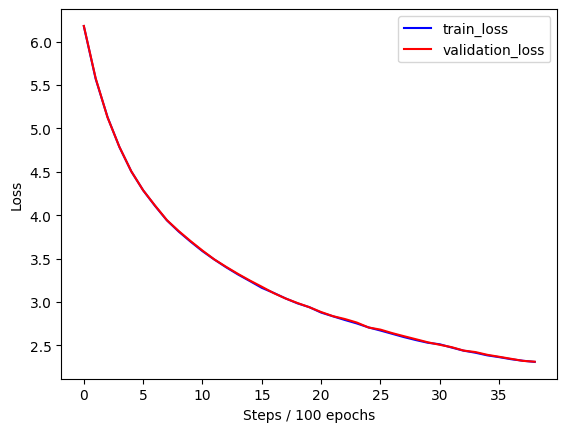

In [20]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
val_loss_list_converted = [i.cpu().detach() for i in val_loss_list]

plt.plot(train_loss_list_converted, 'b', label='train_loss')
plt.plot(val_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps / 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()